<a href="https://colab.research.google.com/github/AbhishekPattnayak23/colourful_dress_detection/blob/main/Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Set up Kaggle API in Colab
Log in to your Kaggle account at Kaggle.

Go to My Account > API > Create New API Token.

A kaggle.json file will be downloaded.

Upload the kaggle.json file to Colab:

In [ ]:
from google.colab import files
files.upload()  # This will open a dialog to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishekpattnayak","key":"e4b157336d8481698814b1986caf4220"}'}

Move the kaggle.json to the correct location:

In [ ]:
!kaggle datasets download -d nguyngiabol/colorful-fashion-dataset-for-object-detection --unzip -p /content/


Dataset URL: https://www.kaggle.com/datasets/nguyngiabol/colorful-fashion-dataset-for-object-detection
License(s): unknown
 88% 92.0M/104M [00:00<00:00, 174MB/s]
100% 104M/104M [00:00<00:00, 143MB/s] 


In [ ]:
!ls /content/


colorful_fashion_dataset_for_object_detection  kaggle.json  sample_data


In [ ]:
# Install ultralytics
!pip install ultralytics

In [ ]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.5.0+cu121 (Tesla T4)


In [ ]:
images_path = '/content/colorful_fashion_dataset_for_object_detection/JPEGImages/'
annotations_path  = '/content/colorful_fashion_dataset_for_object_detection/Annotations_txt/'
path = '/content/colorful_fashion_dataset_for_object_detection/'

In [ ]:
from ultralytics import YOLO

# load pre-trained model
detection_model = YOLO("yolov8m.pt")

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob

In [ ]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])

            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

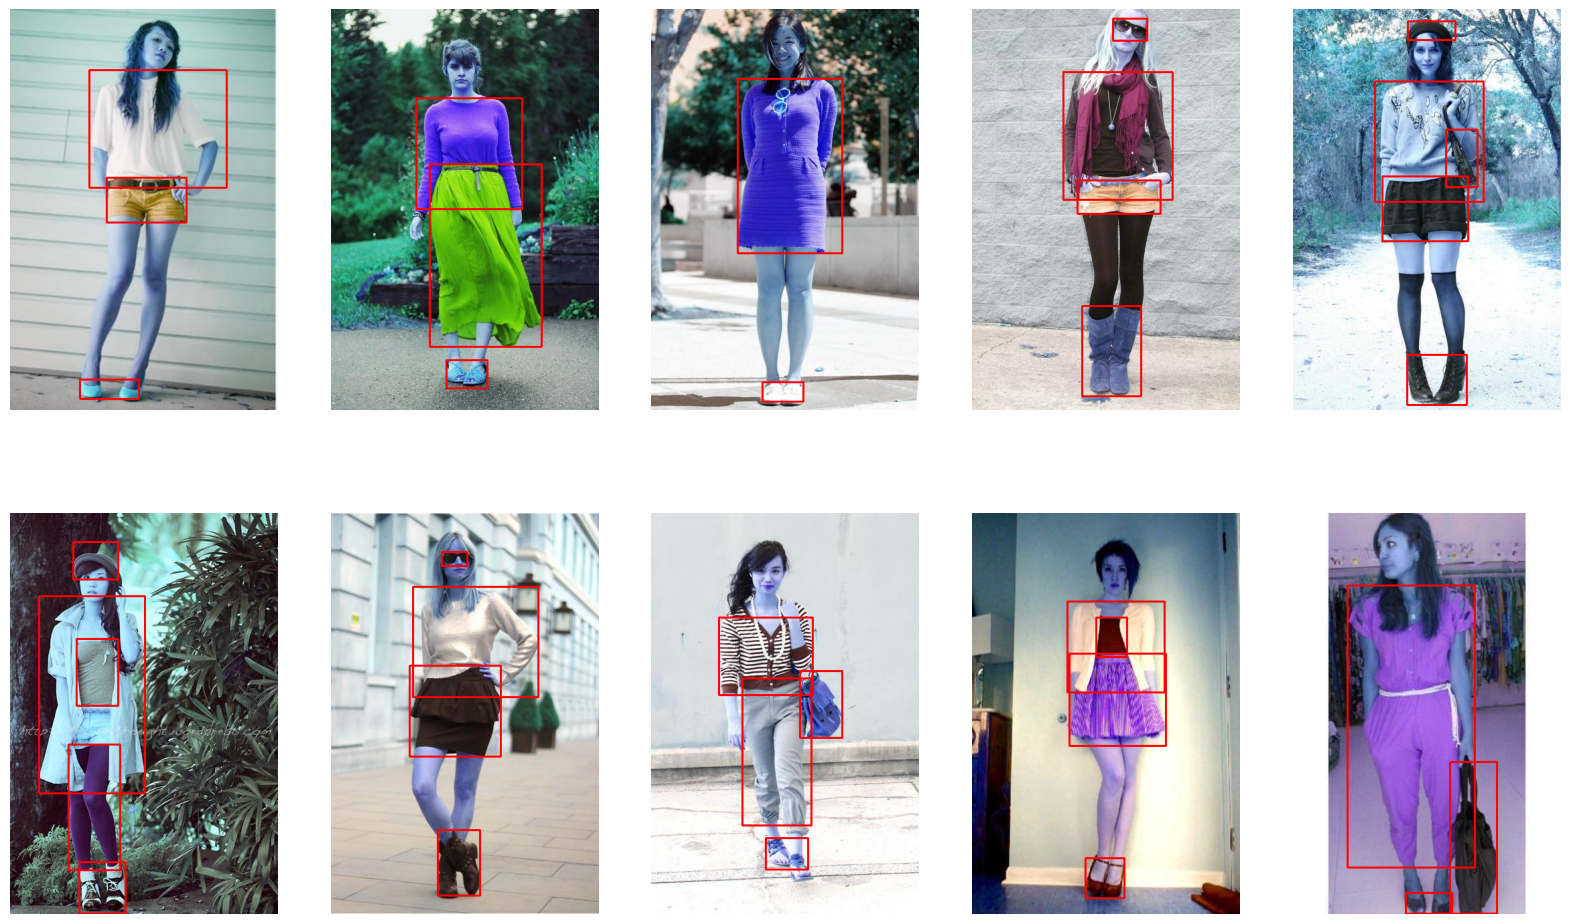

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(20,12))
ls = os.listdir(images_path)
c = 1
for i in random.sample(ls, 10):
    img = cv2.imread(images_path+i)
    i = i.replace('.jpg', '.txt')
    plt.subplot(2,5, c)
    plot_annotations(img, i)
    c+=1

In [ ]:
train = []
with open(path+'/ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'/ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [ ]:
len(train), len(test)

(2145, 537)

In [ ]:
os.makedirs('/content/train/images', exist_ok=True)
os.makedirs('/content/train/labels', exist_ok=True)

os.makedirs('/content/test/images', exist_ok=True)
os.makedirs('/content/test/labels', exist_ok=True)

In [ ]:
# Define paths for train and test datasets
train_path = '/kaggle/working/train/'
test_path = '/kaggle/working/test/'

# Ensure the required directories exist
os.makedirs(train_path + 'images', exist_ok=True)
os.makedirs(train_path + 'labels', exist_ok=True)

os.makedirs(test_path + 'images', exist_ok=True)
os.makedirs(test_path + 'labels', exist_ok=True)

# Copy training data
print('Copying Train Data..!!')
for i in tqdm.tqdm(train):
    shutil.copyfile(images_path + i + '.jpg', train_path + 'images/' + i + '.jpg')
    shutil.copyfile(annotations_path + i + '.txt', train_path + 'labels/' + i + '.txt')

# Copy test data
print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    shutil.copyfile(images_path + i + '.jpg', test_path + 'images/' + i + '.jpg')
    shutil.copyfile(annotations_path + i + '.txt', test_path + 'labels/' + i + '.txt')

Copying Train Data..!!


100%|██████████| 2145/2145 [00:00<00:00, 5369.02it/s]


Copying Test Data..!!


100%|██████████| 537/537 [00:00<00:00, 3061.26it/s]


**Train Custom model**

In [ ]:
#generate data.yaml file which goes as an input to yolov8 for training the custom model
text = """
train: /kaggle/working/train
val: /kaggle/working/test

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")

model.train(data='data.yaml', epochs=5)

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 21.8MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 71.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 1925.33it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 823.75it/s]


val: New cache created: /kaggle/working/test/labels.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.94G      1.312      1.828      1.426          4        640: 100%|██████████| 135/135 [01:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]

                   all        537       2035      0.595      0.678      0.659      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.95G      1.237      1.231      1.352         13        640: 100%|██████████| 135/135 [01:11<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        537       2035      0.642      0.646      0.675      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.92G      1.209      1.128      1.348          3        640: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]

                   all        537       2035      0.659      0.725      0.723      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.83G      1.172      1.026      1.332          5        640: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]

                   all        537       2035      0.752      0.735      0.753      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.91G       1.11      0.932      1.295          7        640: 100%|██████████| 135/135 [01:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]

                   all        537       2035      0.776      0.767      0.791      0.541



5 epochs completed in 0.115 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 52.0MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.39it/s]


                   all        537       2035      0.776      0.766      0.791      0.541
              sunglass         82         82      0.942      0.198       0.38      0.125
                   hat         77         77      0.703      0.779      0.792      0.478
                jacket        179        181      0.826      0.807      0.866      0.674
                 shirt        361        366      0.769      0.874      0.855       0.61
                 pants        114        114      0.787      0.921       0.94      0.745
                shorts        107        107      0.789      0.876      0.796      0.533
                 skirt        186        186      0.751      0.839      0.851      0.663
                 dress        128        128      0.622      0.875      0.846      0.668
                   bag        274        274      0.741      0.734      0.768      0.443
                  shoe        520        520      0.826      0.762       0.82      0.474
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6d43360a60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0